# Visual story telling: Capital Metro data

In [34]:
from pandas import DataFrame, Series
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import numpy as np
import matplotlib.pyplot as plt

In [35]:
metro = pd.read_csv('capmetro_UT.csv')
metro['timestamp'] = pd.to_datetime(metro['timestamp'])
metro['date'] = metro['timestamp'].dt.date
metro[:5]

,timestamp,boarding,alighting,day_of_week,temperature,hour_of_day,month,weekend,date
0,2018-09-01 06:00:00,0,1,Sat,74.82,6,Sep,weekend,2018-09-01
1,2018-09-01 06:15:00,2,1,Sat,74.82,6,Sep,weekend,2018-09-01
2,2018-09-01 06:30:00,3,4,Sat,74.82,6,Sep,weekend,2018-09-01
3,2018-09-01 06:45:00,3,4,Sat,74.82,6,Sep,weekend,2018-09-01
4,2018-09-01 07:00:00,2,4,Sat,74.39,7,Sep,weekend,2018-09-01


Text(0, 0.5, 'Average Alighting Count Per Day')

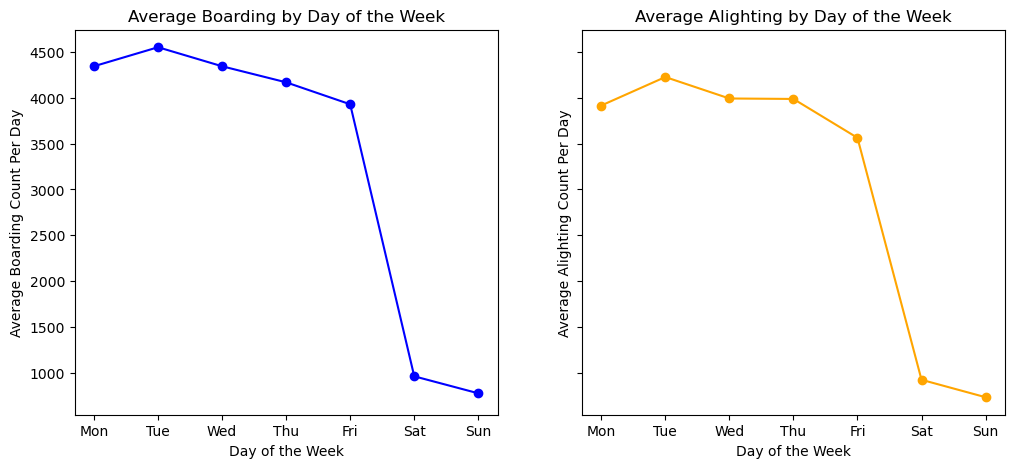

In [36]:
# sum total boarding & alighting in each day, groupby days and then find average by each day
date_week = metro[['date','day_of_week','boarding','alighting']].groupby(['date', 'day_of_week']).sum()
date_week.reset_index('day_of_week',inplace=True)
avg_bor_ali_per_day = date_week.groupby('day_of_week').mean().round(2)

# sort day_of_week from Mon to Sun
day_order = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
avg_bor_ali_per_day['day_of_week_num'] = avg_bor_ali_per_day.index.map(day_order)
avg_bor_ali_per_day.sort_values('day_of_week_num', inplace=True)
avg_bor_ali_per_day


fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 5))
axes[0].plot(avg_bor_ali_per_day.index, avg_bor_ali_per_day['boarding'], marker='o', color='blue')
axes[0].set_title('Average Boarding by Day of the Week')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Average Boarding Count Per Day')

axes[1].plot(avg_bor_ali_per_day.index, avg_bor_ali_per_day['alighting'], marker='o', color='orange')
axes[1].set_title('Average Alighting by Day of the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Average Alighting Count Per Day')

### Analysis on average boarding and alighting by day of the week
The above analysis reveals that the Capital Metro bus system is heavily utilized during the weekdays, with ridership reflecting the daily flow of people to and from the UT-Austin campus. The weekend drop in ridership, with less demand during non-working days. The pattern for alighting mirrors that of boarding, with high counts during the weekdays and lower counts over the weekend. 

In [38]:
metro[:5]

,timestamp,boarding,alighting,day_of_week,temperature,hour_of_day,month,weekend,date
0,2018-09-01 06:00:00,0,1,Sat,74.82,6,Sep,weekend,2018-09-01
1,2018-09-01 06:15:00,2,1,Sat,74.82,6,Sep,weekend,2018-09-01
2,2018-09-01 06:30:00,3,4,Sat,74.82,6,Sep,weekend,2018-09-01
3,2018-09-01 06:45:00,3,4,Sat,74.82,6,Sep,weekend,2018-09-01
4,2018-09-01 07:00:00,2,4,Sat,74.39,7,Sep,weekend,2018-09-01


In [39]:
# Remove weekends, and plot boarding and alighting per day during the period
mask_weekend = (metro['weekend'] == 'weekday')
metro_drop_weekend = metro[mask_weekend][['date','temperature','boarding','alighting']]
b_a_drop_weekend = metro_drop_weekend.groupby('date')[['boarding','alighting']].agg('sum')

In [40]:
mask_weekend = (metro['weekend'] == 'weekday')
metro_drop_weekend = metro[mask_weekend][['date','temperature','boarding','alighting']]
b_a_drop_weekend = metro_drop_weekend.groupby('date')[['boarding','alighting']].agg('sum')

In [41]:
# fit a linear model on boarding
b_a_drop_weekend['date_index'] = np.arange(len(b_a_drop_weekend))

# Fit a linear model on boarding
y_boarding, X_boarding = dmatrices('boarding ~ date_index', data=b_a_drop_weekend, return_type='dataframe')
model_boarding = sm.OLS(y_boarding, X_boarding) 
result_boarding = model_boarding.fit() 

# Predict boarding
y_boarding_actual = b_a_drop_weekend['boarding']
y_boarding_expected = result_boarding.predict(X_boarding)

# Fit a linear model on alighting
y_alighting, X_alighting = dmatrices('alighting ~ date_index', data=b_a_drop_weekend, return_type='dataframe')
model_alighting = sm.OLS(y_alighting, X_alighting) 
result_alighting = model_alighting.fit()

# Predict alighting
y_alighting_actual = b_a_drop_weekend['alighting']
y_alighting_expected = result_alighting.predict(X_alighting)

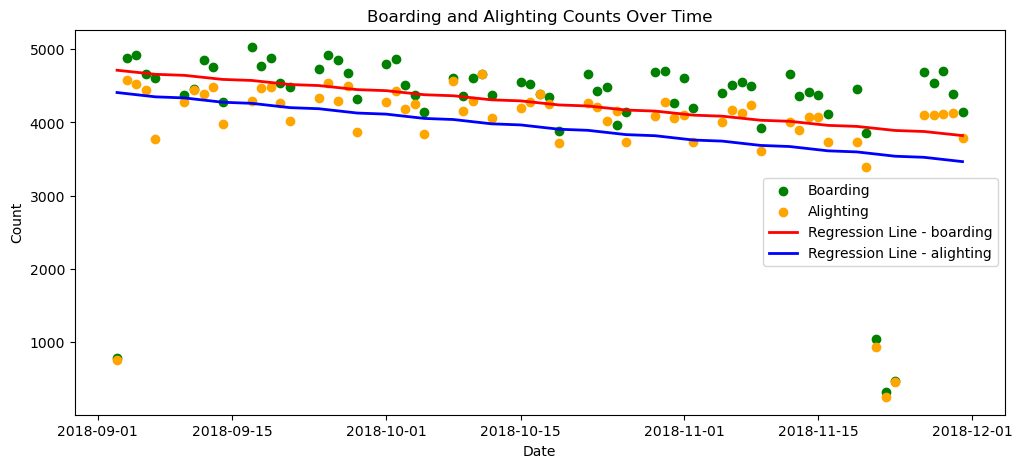

In [42]:
# plot two regressions
fig, ax = plt.subplots(figsize=(12, 5))

ax.scatter(b_a_drop_weekend.index, b_a_drop_weekend['boarding'], marker='o', label='Boarding', color='green')
ax.scatter(b_a_drop_weekend.index, b_a_drop_weekend['alighting'], marker='o', label='Alighting', color='orange')

ax.plot(b_a_drop_weekend.index, y_boarding_expected, color='red', linewidth=2, label='Regression Line - boarding')
ax.plot(b_a_drop_weekend.index, y_alighting_expected, color='blue', linewidth=2, label='Regression Line - alighting')

# Set axis labels and title
ax.set(xlabel='Date', ylabel='Count', title='Boarding and Alighting Counts Over Time')
ax.legend()
plt.show()

### Interpretation of Weekday Boarding and Alighting Trends
The graph illustrates the daily boarding and alighting counts on the Capital Metro bus network around the UT-Austin campus during weekdays from September to November 2018, with weekends excluded from the analysis.

1. Downward Trend Over Time:
Both boarding and alighting counts display a slight but noticeable downward trend throughout the observed period, as shown by the negative slopes of the red (boarding) and blue (alighting) regression lines. This trend suggests a gradual decline in bus ridership on weekdays over time, potentially influenced by factors such as the progression of the academic semester or seasonal weather changes.

2. Outliers and Anomalies:
Significant outliers are visible, particularly at the beginning and end of the observation period, where both boarding and alighting counts drop sharply. These anomalies likely correspond to external events such as the Labor Day or Thanksgiving holidays, when campus activity decreases, leading to reduced bus usage.

3. Boarding vs. Alighting Disparity:
Throughout the period, the boarding counts (green points) consistently exceed the alighting counts (orange points). This disparity suggests that the UT campus serves as a primary starting point for many bus trips, with fewer passengers getting off the bus within the analyzed area, potentially disembarking at locations outside the campus.

<Figure size 1000x600 with 0 Axes>

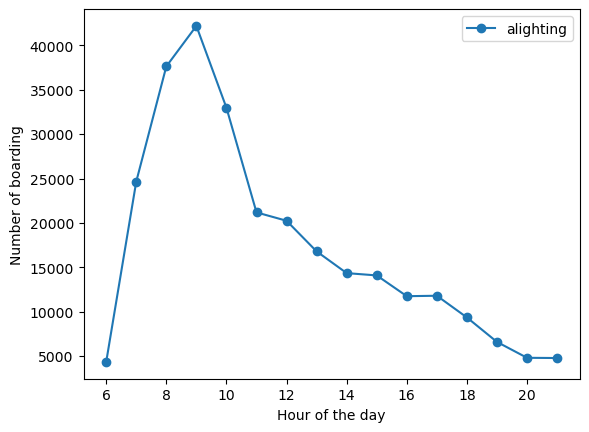

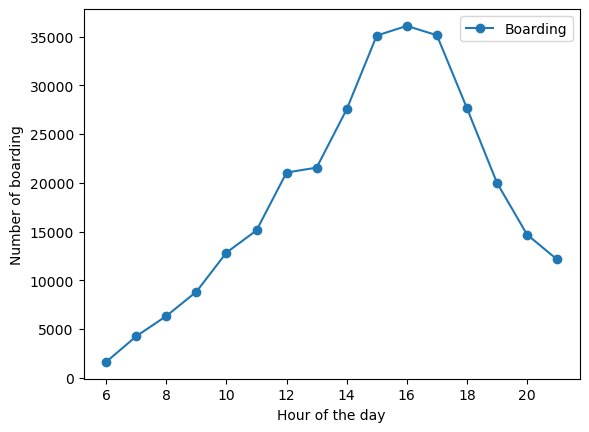

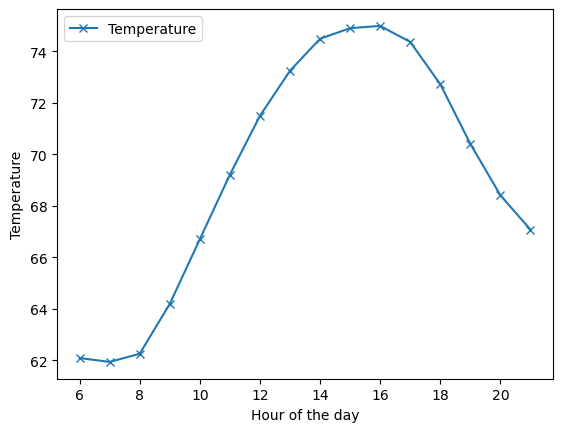

In [44]:
number_boarding_by_hour = metro[['boarding','hour_of_day']].groupby('hour_of_day').sum()
number_alighting_by_hour = metro[['alighting','hour_of_day']].groupby('hour_of_day').sum()
avg_temperature_by_hour = metro[['temperature','hour_of_day']].groupby('hour_of_day').mean()

plt.figure(figsize=(10, 6))

# boarding_alighting.plot()
number_alighting_by_hour.plot(y='alighting', label='alighting', marker='o', xlabel='Hour of the day', ylabel='Number of boarding')
number_boarding_by_hour.plot(y='boarding', label='Boarding', marker='o', xlabel='Hour of the day', ylabel='Number of boarding')
avg_temperature_by_hour.plot(y='temperature', label='Temperature', marker='x', xlabel='Hour of the day', ylabel='Temperature')

plt.legend()
plt.show()

### Analysis on hour of the day
These three graphs collectively provide a view of the relationship between boarding and alighting patterns, as well as temperature fluctuations, over the period of interest on the Capital Metro bus around the UT-Austin campus.

1. Alighting by Hour of the Day
The alighting count peaks around 8-9 AM, which suggests that many passengers are reaching campus during the morning hours. After the peak, there's a steady decline in alighting counts, which continues throughout the day until the evening.

2. Boarding by Hour of the Day
The second graph illustrates the boarding patterns, showing a different peak time compared to alighting. The number of boarding passengers increases gradually through the morning, peaking around 4-5 PM. This suggests that a significant portion of the bus usage occurs in the afternoon as people leave campus or work to head home.
There is a symmetry between alighting and boarding, suggesting that many people who alighted in the morning are boarding again in the afternoon.

3. Temperature by Hour of the Day
The temperature pattern aligns with the ridership trends, indicating that temperature may play a role in how and when passengers choose to use the bus service. The afternoon heat coincides with higher boarding, possibly due to people opting for the bus rather than walking in warmer weather.

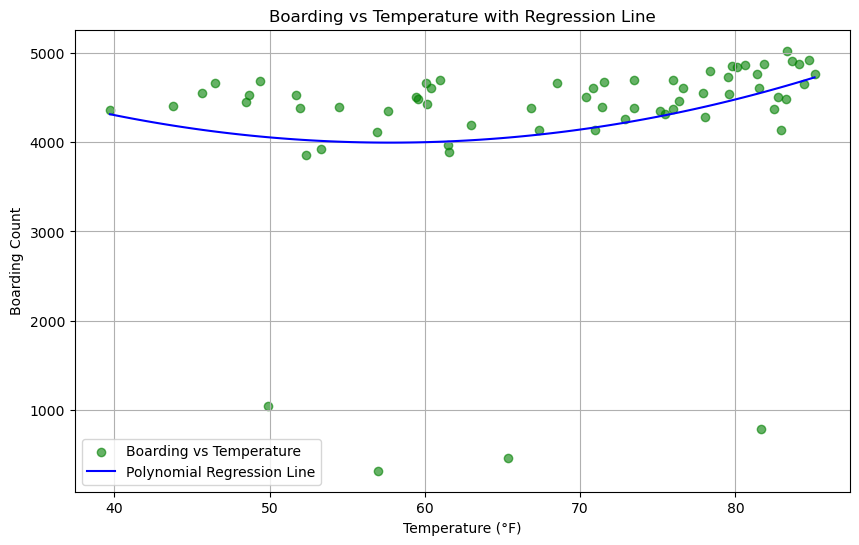

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Group data by date and calculate sums for boarding, alighting, and average temperature
b_a_date = metro_drop_weekend.groupby('date')[['boarding', 'alighting']].sum()
temp_date = metro_drop_weekend.groupby('date')['temperature'].mean()
b_a_date['temperature'] = temp_date

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(b_a_date['temperature'], b_a_date['boarding'], color='green', alpha=0.6, label='Boarding vs Temperature')

# Fit a second-degree polynomial regression
coefficients = np.polyfit(b_a_date['temperature'], b_a_date['boarding'], deg=2)
poly = np.poly1d(coefficients)

# Generate a smooth range of temperature values for plotting the regression line
temperature_range = np.linspace(b_a_date['temperature'].min(), b_a_date['temperature'].max(), 100)
y_poly_pred = poly(temperature_range)

# Plot the polynomial regression line using the generated temperature range
ax.plot(temperature_range, y_poly_pred, color='blue', label='Polynomial Regression Line')

# Set labels, title, and legend
ax.set(xlabel='Temperature (°F)', ylabel='Boarding Count', title='Boarding vs Temperature with Regression Line')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()


### Interpretation of the Temperature and Boarding/Alighting

The polynomial regression line suggests a U-shaped relationship between temperature and boarding counts. This indicates that at both lower and higher temperatures, boarding counts tend to be higher, while in the mid-range temperatures, the boarding counts dip slightly.